In [1]:
import os
# from numba import jit
from tqdm import tqdm

import numpy as np
import pandas as pd

import sklearn 
from sklearn.metrics import matthews_corrcoef

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.colors as colors 
from matplotlib import cm

from my_utilities.constants import AMINOACIDS, aminoacid_name_from_1l
from my_utilities.svd import SVD_representation
from my_utilities.pair_contacts import *

In [2]:
DIR_PATH = "./cg_contacts/"
DAA_CONTACT_CUTOFF = 5

In [3]:
df = load_data(DIR_PATH)
df["aa_contact"] = df.apply(lambda row: row["daa"] < DAA_CONTACT_CUTOFF, axis=1)

100%|██████████████████████████████████████| 6442/6442 [00:12<00:00, 514.24it/s]


In [5]:
aas = df["aa1"].unique()
aas.sort()

In [6]:
dfg = df.groupby(["aa1","aa2"])
dfnrg = {}
for g in dfg: #dfgg.keys():
    g_key, g_df = g
    if (g_key[1],g_key[0]) not in dfnrg.keys():
        dfnrg[g_key] = pd.concat([dfg.get_group(g_key), dfg.get_group((g_key[1],g_key[0]))])

In [7]:
d2vals = {}
for p in dfnrg:
    d2vals[p] = get_optimal_d2(dfnrg[p])

In [7]:
len(d2vals)

171

In [14]:
def plot_contact_hists(dfx, N_BINS=100, plot_mcc_curve=False, save_to=None):
    """
    """
    aac_hist, aac_edges = np.histogram(dfx[dfx["aa_contact"]]["dcg"], N_BINS)
    aac_rdf = aac_hist / ((3/4)*(np.pi)*aac_edges[1:]**3)

    aanc_hist, aanc_edges = np.histogram(dfx[~dfx["aa_contact"]]["dcg"], N_BINS)
    aanc_rdf = aanc_hist / ((3/4)*(np.pi)*aanc_edges[1:]**3)

    fig, ax = plt.subplots()
    ax.plot(aac_edges[1:], aac_rdf, label="contact")
    ax.plot(aanc_edges[1:], aanc_rdf, label="no contact")
    ax.tick_params(direction="in")
    ax.set_xlabel("d [Å]")
    ax.set_ylabel("n")
    ax.legend()

    if plot_mcc_curve:
        rs, mccs = [], []
        for r in tqdm(np.linspace(min(aac_edges[0], aanc_edges[0]),
                                  max(aac_edges[-1], aanc_edges[-1]), 100)):
            rs.append(r)
            mccs.append(
                sklearn.metrics.matthews_corrcoef(dfx["aa_contact"], dfx["dcg"] < r)
            )
        ax1 = ax.twinx()
        ax1.plot(rs, mccs, color="red",linestyle="dashed")
        ax1.tick_params(axis='y', labelcolor="red")
        ax1.set_ylabel('MCC', color="red")

    if save_to is None:
        plt.show()
    else:
        plt.savefig(save_to)

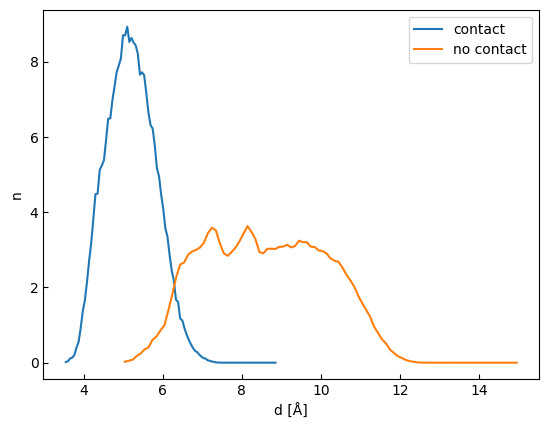

In [15]:
plot_contact_hists(dfnrg['L','V'], N_BINS=100)

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.77it/s]


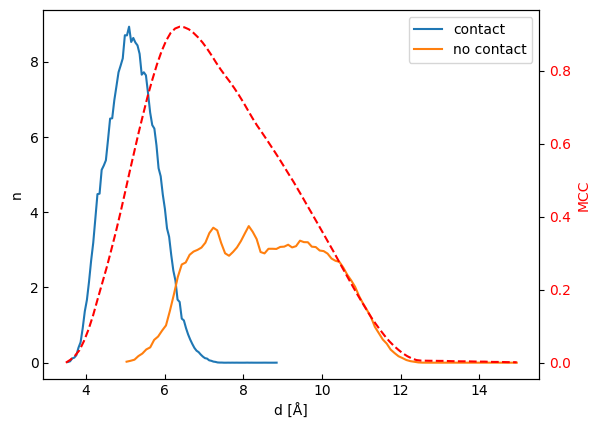

In [16]:
plot_contact_hists(dfnrg['L','V'], N_BINS=100, plot_mcc_curve=True, save_to=None)

In [21]:
dfnrg

{('C',
  'C'):      aa1 aa2 dij    dcg    daa  aa_contact
 4350   C   C   1  8.253  8.253       False
 4368   C   C   3  7.273  7.273       False
 4369   C   C   2  9.528  9.528       False
 1104   C   C   4  7.035  7.035       False
 521    C   C  37  4.232  4.232        True
 ...   ..  ..  ..    ...    ...         ...
 393    C   C   3  3.885  3.885        True
 129    C   C  23  2.176  2.176        True
 958    C   C   1  7.695  7.695       False
 3820   C   C   5  1.995  1.995        True
 544    C   C  68  1.991  1.991        True
 
 [17716 rows x 6 columns],
 ('C',
  'D'):      aa1 aa2  dij     dcg    daa  aa_contact
 1377   C   D    7   7.337  6.899       False
 3757   C   D   18   6.507  6.238       False
 4343   C   D    1   7.052  6.709       False
 4349   C   D    2   8.193  7.716       False
 4358   C   D   56  10.486  9.470       False
 ...   ..  ..  ...     ...    ...         ...
 807    D   C  115   4.555  3.690        True
 1391   D   C    3   6.374  5.650       False
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: ('A', 'L')

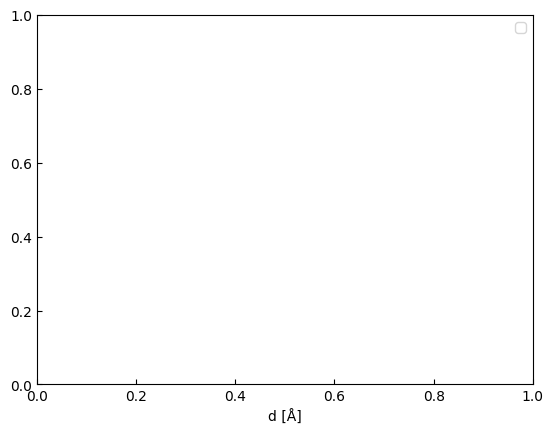

In [20]:
N_BINS = 100

fig, ax = plt.subplots()
ax.tick_params(direction="in")
ax.set_xlabel("d [Å]")
ax.legend()

dfx = dfnrg['A','L']

aac_hist, aac_edges = np.histogram(dfx[dfx["aa_contact"]]["dcg"], N_BINS)
aac_rdf = aac_hist / ((3/4)*(np.pi)*aac_edges[1:]**3)

aanc_hist, aanc_edges = np.histogram(dfx[~dfx["aa_contact"]]["dcg"], N_BINS)
aanc_rdf = aanc_hist / ((3/4)*(np.pi)*aanc_edges[1:]**3)

rs, mccs = [], []
for r in tqdm(np.linspace(min(aac_edges[0], aanc_edges[0]),
                          max(aac_edges[-1], aanc_edges[-1]), 100)):
    rs.append(r)
    mccs.append(
        sklearn.metrics.matthews_corrcoef(dfx["aa_contact"], dfx["dcg"] < r)
    )

ax.plot(rs, mccs)
ax.set_ylabel('MCC') # , color="red")

plt.show()

In [11]:
aas

array(['C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'V', 'W', 'Y'], dtype=object)

In [12]:
N = aas.shape[0]
d2vals_arr = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        ni, nj = aas[i], aas[j]
        d2vals_arr[i,j] = d2vals[ni,nj]
        d2vals_arr[j,i] = d2vals[ni,nj]

In [13]:
with open("./d2vals.txt", "w") as f:
    f.write(str(d2vals))

In [14]:
d2vals

{('C', 'C'): 4.999043806942041,
 ('C', 'D'): 5.357762026439511,
 ('C', 'E'): 5.7731360936500105,
 ('C', 'F'): 6.1614431587892815,
 ('C', 'H'): 5.923183024288514,
 ('C', 'I'): 6.074561570903881,
 ('C', 'K'): 5.667076648255435,
 ('C', 'L'): 5.7923127475499765,
 ('C', 'M'): 5.772447898454652,
 ('C', 'N'): 5.500139099343675,
 ('C', 'P'): 5.524386773960173,
 ('C', 'Q'): 6.016821707360994,
 ('C', 'R'): 6.3964550753386,
 ('C', 'S'): 4.999218879205529,
 ('C', 'T'): 5.717701414454972,
 ('C', 'V'): 5.813139827144093,
 ('C', 'W'): 6.518099513651693,
 ('C', 'Y'): 6.404380891806739,
 ('D', 'D'): 6.2757599923561065,
 ('D', 'E'): 6.540752481951831,
 ('D', 'F'): 6.6116609943887585,
 ('D', 'H'): 6.49632865853111,
 ('D', 'I'): 6.541152663279169,
 ('D', 'K'): 6.483229850260708,
 ('D', 'L'): 6.264225339318206,
 ('D', 'M'): 6.3170137412290135,
 ('D', 'N'): 6.16718427131295,
 ('D', 'P'): 6.021165141987643,
 ('D', 'Q'): 6.471280909474635,
 ('D', 'R'): 6.771547128988349,
 ('D', 'S'): 5.671040993482821,
 ('D',

In [15]:
from  matplotlib.cm import ScalarMappable

In [16]:
np.savetxt("contact_d2_data.csv", d2vals_arr)

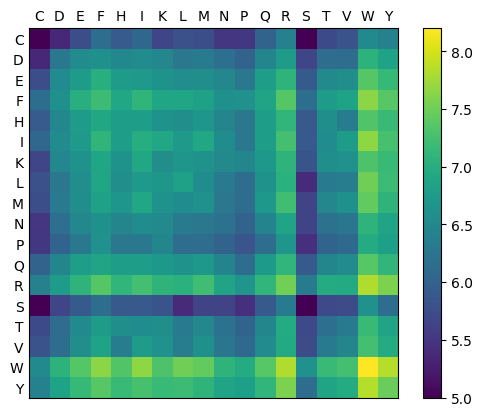

In [17]:
fig, ax = plt.subplots()
ax.imshow(d2vals_arr)
ax.set_xticks(range(len(aas)), aas)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
ax.set_yticks(range(len(aas)), aas)

scmap = ScalarMappable(norm=None)
scmap.set_array(d2vals_arr)
scmap.autoscale()
fig.colorbar(scmap, cmap=None, ax=ax)

plt.show()

In [43]:
u, s, vh = np.linalg.svd(d2vals_arr)

In [61]:
s1 = s[0]

In [58]:
u1 = u[:,0]

In [59]:
vh1 = vh[0,:]

In [55]:
m1 = np.zeros((18,18))

In [62]:
for i in range(18):
    for j in range(18):
        m1[i][j] = u1[i]*s1*vh1[j]

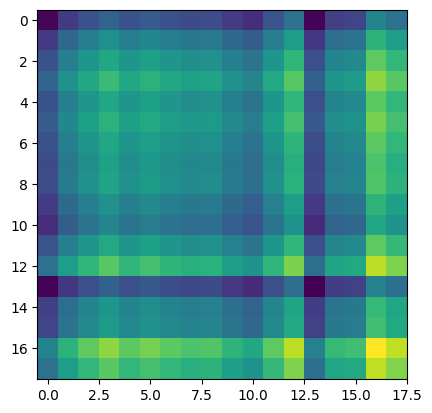

In [64]:
plt.imshow(m1)

In [85]:
s1

118.60291744656233

In [91]:
aas

array(['C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'V', 'W', 'Y'], dtype=object)

In [97]:
vh1

array([-0.20799844, -0.22740109, -0.23795322, -0.24646996, -0.23788943,
       -0.24242963, -0.23765508, -0.23471991, -0.23597267, -0.22783849,
       -0.22252034, -0.2380431 , -0.25284067, -0.20691224, -0.23006163,
       -0.23219535, -0.2629743 , -0.25338989])

In [99]:
n = vh1.shape[0]

for aa, x, y in zip(aas, u1, vh1):
    print(f"{aa} & {x:.8f} & {y:.8f} \\\\")

C & -0.20799844 & -0.20799844 \\
D & -0.22740109 & -0.22740109 \\
E & -0.23795322 & -0.23795322 \\
F & -0.24646996 & -0.24646996 \\
H & -0.23788943 & -0.23788943 \\
I & -0.24242963 & -0.24242963 \\
K & -0.23765508 & -0.23765508 \\
L & -0.23471991 & -0.23471991 \\
M & -0.23597267 & -0.23597267 \\
N & -0.22783849 & -0.22783849 \\
P & -0.22252034 & -0.22252034 \\
Q & -0.23804310 & -0.23804310 \\
R & -0.25284067 & -0.25284067 \\
S & -0.20691224 & -0.20691224 \\
T & -0.23006163 & -0.23006163 \\
V & -0.23219535 & -0.23219535 \\
W & -0.26297430 & -0.26297430 \\
Y & -0.25338989 & -0.25338989 \\


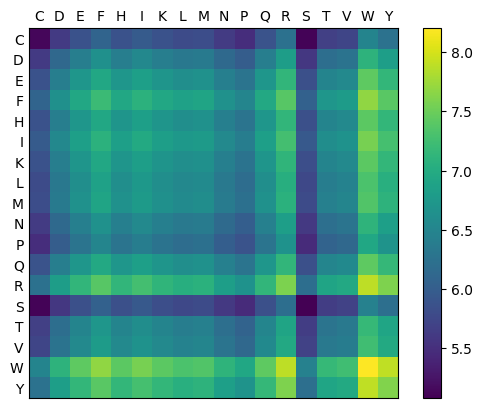

In [18]:
svda_d1 = SVD_representation(d2vals_arr, 1)

fig, ax = plt.subplots()
ax.imshow(svda_d1)
ax.set_xticks(range(len(aas)), aas)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
ax.set_yticks(range(len(aas)), aas)

scmap = ScalarMappable(norm=None)
scmap.set_array(svda_d1)
scmap.autoscale()
fig.colorbar(scmap, cmap=None, ax=ax)

plt.show()

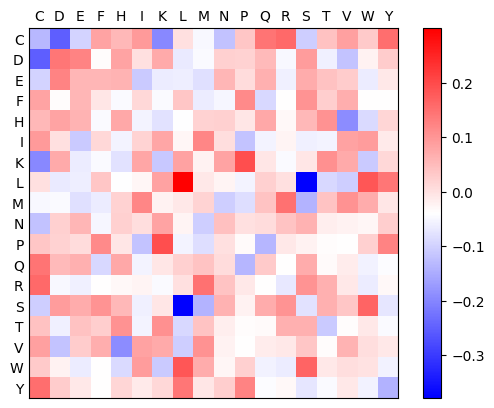

In [19]:
M = d2vals_arr - svda_d1
# M = np.absolute(d2vals_arr - svda_d1)

fig, ax = plt.subplots()
M_axr = ax.imshow(M, cmap="bwr")
ax.set_xticks(range(len(aas)), aas)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
ax.set_yticks(range(len(aas)), aas)

# scmap = ScalarMappable(norm=None)
# scmap.set_array(M)
# scmap.autoscale()
fig.colorbar(M_axr, cmap="bwr", ax=ax)
# fig.colorbar(scmap, ax=ax)

plt.show()

(array([  2.,   2.,   4.,  18.,  74., 107.,  81.,  29.,   6.,   1.]),
 array([-0.37815341, -0.31039692, -0.24264043, -0.17488394, -0.10712744,
        -0.03937095,  0.02838554,  0.09614203,  0.16389853,  0.23165502,
         0.29941151]),
 <BarContainer object of 10 artists>)

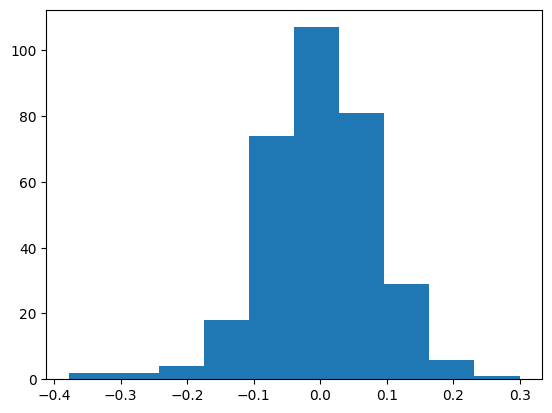

In [28]:
plt.hist(M.flatten(), bins=10)

In [36]:
np.argmax(aas == 'S'), np.argmax(aas == 'L')

(13, 7)

In [37]:
M[13,7]

-0.3781534131457933

In [42]:
np.absolute(M).mean()

0.0649342995173075

In [31]:
M.argmin(), M.min()

(139, -0.3781534131457951)

In [20]:
dvals = np.arange(1,18)
errs = []
for d in dvals:
    svda1 = SVD_representation(d2vals_arr, d)
    errs.append(np.mean(np.abs(d2vals_arr - svda1)))

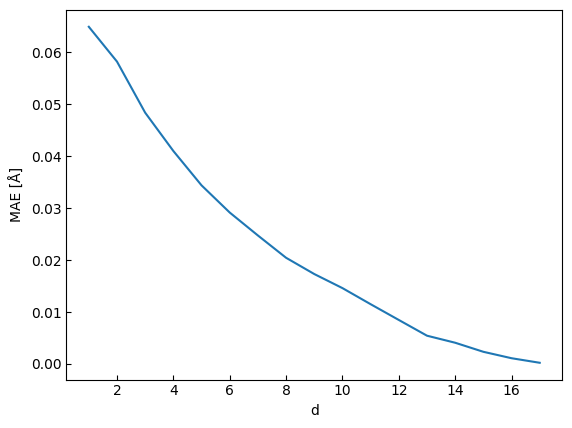

In [21]:
fig, ax = plt.subplots()
ax.plot(dvals, errs)
ax.set_ylabel("MAE [Å]")
ax.set_xlabel("d")
ax.tick_params(direction="in")
plt.show()

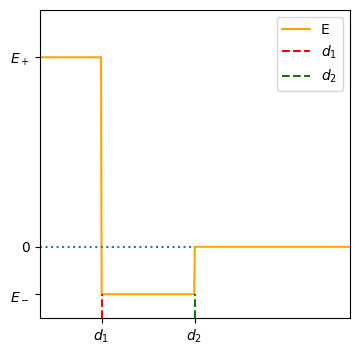

In [481]:
bottom = -1.5
left = 0

d1 = 20
d2 = 50
maxval = 100
bins = 500
factor = bins/maxval

X = np.linspace(0,100,bins)
Y = np.zeros(bins)

Y[:round(factor*d1)] = 4
Y[round(factor*d1):round(factor*d2)] = -1


plt.figure(figsize=(4,4))

plt.plot(X,Y, color="orange", label="E")
plt.vlines(d1,bottom,-1, color="red", linestyle="dashed", label="$d_1$")
plt.vlines(d2,bottom,-1, color="green", linestyle="dashed", label="$d_2$")
plt.hlines(0,0,d2, linestyle="dotted")

plt.xlim(left,maxval)
plt.ylim(bottom,5)

plt.xticks([d1,d2], labels=["$d_1$","$d_2$"])
plt.yticks([-1,0,4], labels=["$E_-$",0,"$E_+$"])
plt.legend()
plt.show()

DIR_PATH = "./cg_contacts/"

In [23]:
fnames = os.listdir(DIR_PATH)

In [37]:
dfs = []
for fname in tqdm(fnames):
    try:
        dfs.append(
            pd.read_csv(DIR_PATH + fname,
                        delim_whitespace=True,
                        index_col=False,
                        names=["aa1", "aa2", "dij", "dcg", "daa"],
                        skiprows=1)
        )
        
    except:
        print(f"Problem with file: {fname}")

 58%|█████████████████████████████                     | 3749/6443 [00:06<00:04, 613.29it/s]

Problem with file: runme.sh


100%|██████████████████████████████████████████████████| 6443/6443 [00:10<00:00, 589.16it/s]


In [38]:
df = pd.concat(dfs)

In [78]:
N_BINS = 100
DAA_CONTACT_CUTOFF = 5

In [84]:
df["aa_contact"] = df.apply(lambda row: row["daa"] < DAA_CONTACT_CUTOFF, axis=1)

In [143]:
len(df)

11818010

In [123]:
df.head()

,aa1,aa2,dij,dcg,daa,aa_contact
0,D,F,1,6.693,6.319,False
1,M,F,2,7.283,5.421,False
2,M,D,1,6.490,5.718,False
3,N,F,3,10.526,9.412,False
4,N,D,2,5.950,4.843,True


<Axes: xlabel='aa1'>

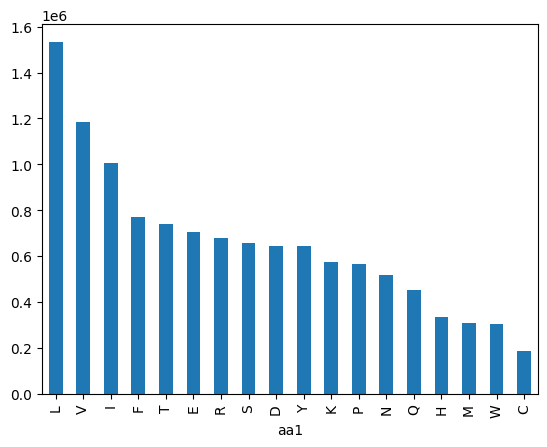

In [155]:
df.groupby("aa1").count().sort_values("aa2", ascending=False)["aa2"].plot.bar()

In [295]:
dfgg = df.groupby(["aa1","aa2"]).groups

### Groups without repetitions (a,b) is joined with (b,a)

In [187]:
dfnrg = {}
for k in dfgg.keys():
    if (k[1],k[0]) not in dfnrg.keys():
        dfnrg[k] = pd.concat([dfg.get_group(k), dfg.get_group((k[1],k[0]))])

In [192]:
def plot_contact_hists(dfx, N_BINS=100):
    aac_hist, aac_edges = np.histogram(dfx[dfx["aa_contact"]]["dcg"], N_BINS)
    aac_rdf = aac_hist / ((3/4)*(np.pi)*aac_edges[1:]**3)

    aanc_hist, aanc_edges = np.histogram(dfx[~dfx["aa_contact"]]["dcg"], N_BINS)
    aanc_rdf = aanc_hist / ((3/4)*(np.pi)*aanc_edges[1:]**3)

    fig, ax = plt.subplots()
    ax.plot(aac_edges[1:], aac_rdf, label="contact")
    ax.plot(aanc_edges[1:], aanc_rdf, label="no contact")
    ax.tick_params(direction="in")
    ax.set_xlabel("d [Å]")
    ax.set_ylabel("n")
    plt.legend()
    plt.show()

## Specific case, Threonine & Tryptophane ('cause not that many cases?)

In [198]:
df_TW = dfnrg[("T","W")]

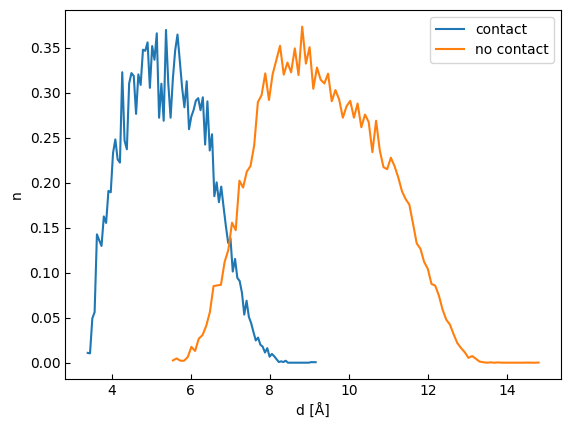

In [199]:
plot_contact_hists(df_TW)

In [205]:
rs = []
mccs = []

for r in tqdm(np.linspace(1, 10, 100)):
    rs.append(r)
    mccs.append(
        sklearn.metrics.matthews_corrcoef(df_TW["aa_contact"], df_TW["dcg"] < r)
    )

100%|████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.26it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


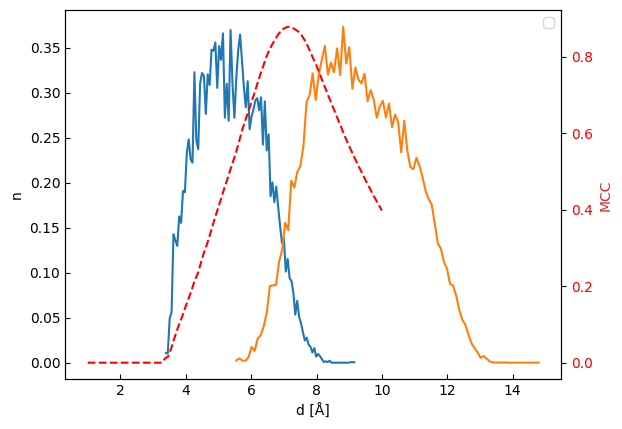

In [217]:
dfx = df_TW

aac_hist, aac_edges = np.histogram(dfx[dfx["aa_contact"]]["dcg"], N_BINS)
aac_rdf = aac_hist / ((3/4)*(np.pi)*aac_edges[1:]**3)

aanc_hist, aanc_edges = np.histogram(dfx[~dfx["aa_contact"]]["dcg"], N_BINS)
aanc_rdf = aanc_hist / ((3/4)*(np.pi)*aanc_edges[1:]**3)

fig, ax = plt.subplots()
ax.plot(aac_edges[1:], aac_rdf, label="contact")
ax.plot(aanc_edges[1:], aanc_rdf, label="no contact")
ax.tick_params(direction="in")
ax.set_xlabel("d [Å]")
ax.set_ylabel("n")

ax1 = ax.twinx()
ax1.plot(rs, mccs, color="red",linestyle="dashed")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_ylabel('MCC', color=color)

plt.legend()
plt.show()

In [270]:
mccs

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.011003302590412494,
 0.015561225010906052,
 0.03479962933407662,
 0.06029063684987388,
 0.08386173026933114,
 0.10450925209880407,
 0.12469722012729151,
 0.14797458296583998,
 0.16883785492089265,
 0.19069496624167495,
 0.21500045626045952,
 0.2321554301326863,
 0.2582558603547356,
 0.2847295699071516,
 0.30662899482300426,
 0.3308381487674944,
 0.3571343118432322,
 0.3831541181580969,
 0.40659240716239003,
 0.4316614109630604,
 0.4565724213943881,
 0.47929425575246193,
 0.5045258809992798,
 0.5278567964558122,
 0.5515803264488901,
 0.5797170840462386,
 0.6082637951359349,
 0.6318655172210578,
 0.6561006232489149,
 0.678484963555707,
 0.7020244801178659,
 0.7271322983888553,
 0.751284432964535,
 0.7738037980256861,
 0.7965498084088941,
 0.8156318583868156,
 0.830721064968442,
 0.8438186962297888,
 0.8567205464688898,
 0.866983112

In [253]:
realvals = df_TW["aa_contact"].to_numpy()
dcgs = df_TW["dcg"].to_numpy()

In [262]:
def fun(r,realvals,dcgs):
#     preds =
    return -sklearn.metrics.matthews_corrcoef(realvals, dcgs < r)

In [263]:
fun(7,realvals,dcgs)

-0.8735173403727619

In [271]:
minres = minimize(fun,5,args=(realvals,dcgs), tol=0.005,method="Powell")

In [274]:
minres.x[0]

7.16722828787032

In [110]:
df["dcg"] > 4, 

(0       True
 1       True
 2       True
 3       True
 4       True
         ... 
 5903    True
 5904    True
 5905    True
 5906    True
 5907    True
 Name: dcg, Length: 11818010, dtype: bool,
 0       False
 1       False
 2       False
 3       False
 4        True
         ...  
 5903    False
 5904     True
 5905    False
 5906    False
 5907     True
 Name: aa_contact, Length: 11818010, dtype: bool)

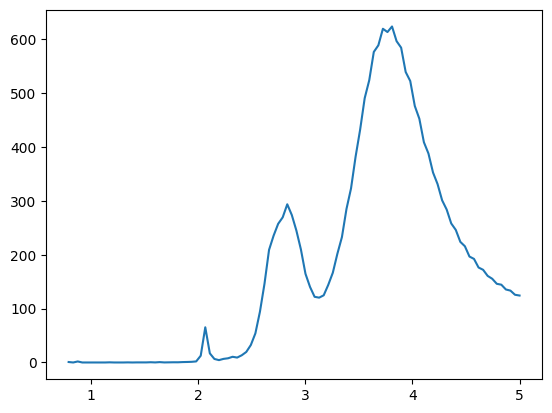

In [82]:
daas = dfc["daa"].to_numpy()\

hist, edges = np.histogram(daas, N_BINS)
rdf = hist / ((3/4)*(np.pi)*edges[1:]**3)
plt.plot(edges[1:], rdf)
plt.show()

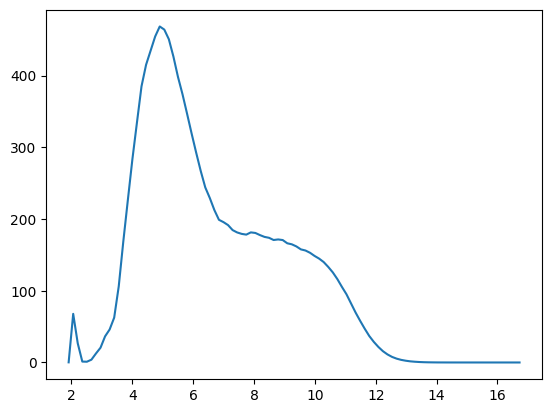

In [77]:
daas = df["dcg"].to_numpy()\

hist, edges = np.histogram(daas, N_BINS)
rdf = hist / ((3/4)*(np.pi)*edges[1:]**3)
plt.plot(edges[1:], rdf)
plt.show()

(array([1.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 6.00000e+00, 8.00000e+00,
        8.00000e+00, 1.90000e+01, 4.10000e+01, 1.05900e+03, 1.05000e+03,
        3.02000e+02, 5.67000e+02, 8.11000e+02, 2.41300e+03, 8.14000e+03,
        2.02990e+04, 2.79130e+04, 3.38860e+04, 2.87310e+04, 2.07870e+04,
        1.89450e+04, 2.55900e+04, 3.97080e+04, 6.26300e+04, 9.18190e+04,
        1.25571e+05, 1.52327e+05, 1.72147e+05, 1.75041e+05, 1.69494e+05,
        1.54400e+05, 1.41978e+05, 1.27817e+05, 1.13925e+05, 1.03918e+05,
        9.73240e+04, 9.00890e+04, 8.68230e+04, 8.27860e+04, 8.13510e+04,
        7.85730e+04, 7.75130e+04, 7.46370e+04, 7.51020e+04, 7.36730e+04,
        7.34060e+04, 7.23550e+04, 7.42310e+04, 7.52470e+04, 8.03430e+04,
        8.51640e+04, 9.47160e+04, 1.04523e+05, 1.19641e+05, 1.30783e+05,
        1.39994e+05, 1.43661e+05, 1.50343e+05, 1.52705e+05, 1.58803e+05,
        1.61592e+05, 1.68344e+05, 1.70942e+05, 1.75

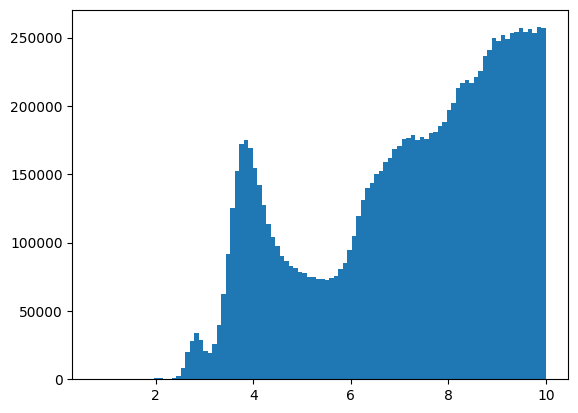

In [57]:
plt.hist(df["daa"].to_numpy(), bins=100)

<Axes: >

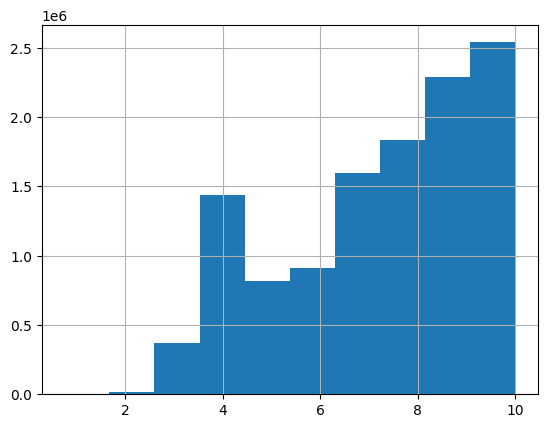

In [52]:
df["daa"].hist()

In [297]:
dfg = df.groupby(["aa1","aa2"])

In [304]:
for g in dfg:
    g_key, g_df = g
    print(g_key)
    input()

('C', 'C')


KeyboardInterrupt: Interrupted by user

In [48]:
for aapair, d in dfg:
    print(aapair)
    input()
    print(type(d))
    input()

('C', 'C')

<class 'pandas.core.frame.DataFrame'>


KeyboardInterrupt: Interrupted by user

In [31]:
pd.read_csv(fname, delim_whitespace=True, index_col=False, names=["aa1", "aa2", "dij", "dcg", "daa"], skiprows=1)

,aa1,aa2,dij,dcg,daa
0,D,F,1,6.693,6.319
1,M,F,2,7.283,5.421
2,M,D,1,6.490,5.718
3,N,F,3,10.526,9.412
4,N,D,2,5.950,4.843
...,...,...,...,...,...
5716,T,D,75,10.889,9.611
5717,T,K,60,11.738,9.825
5718,T,Y,3,7.714,5.734
5719,T,F,2,9.535,8.242


In [26]:
with open(fname, "r") as f:
    print(f.readlines())

['#aaij dij    dcg    d_aa\n', 'D F    1   6.693   6.319\n', 'M F    2   7.283   5.421\n', 'M D    1   6.490   5.718\n', 'N F    3  10.526   9.412\n', 'N D    2   5.950   4.843\n', 'N M    1   5.124   4.179\n', 'R F    4  10.574   9.486\n', 'R D    3   5.646   4.977\n', 'R M    2  11.283   9.898\n', 'R N    1   8.869   7.027\n', 'V F    5   6.835   5.454\n', 'V D    4   7.676   6.674\n', 'V M    3   8.576   6.077\n', 'V N    2   9.395   8.058\n', 'V R    1   8.319   7.725\n', 'I F    6  10.468   7.593\n', 'I D    5   9.004   7.615\n', 'I M    4   6.820   5.034\n', 'I N    3   6.219   5.033\n', 'I R    2  10.448   7.981\n', 'I V    1   6.208   3.823\n', 'D D    6   9.644   7.939\n', 'D M    5   9.924   9.305\n', 'D N    4   6.353   5.555\n', 'D R    3   8.902   5.583\n', 'D V    2   8.794   8.114\n', 'D I    1   4.973   3.432\n', 'E D    7  10.475   9.036\n', 'E R    4   6.767   5.008\n', 'E V    3   6.793   6.026\n', 'E I    2   9.552   8.342\n', 'E D    1   8.363   6.790\n', 'F V    4